### Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns               #!pip install seaborn
import matplotlib.pyplot as plt    #!pip install matplotlib

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import keras
import tensorflow as tf
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical   #!pip install keras/conda install keras


2024-06-17 12:21:20.486277: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-17 12:21:20.488814: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-17 12:21:20.514914: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-17 12:21:20.665121: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-17 12:21:22.736867: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

# Data Preparation
As of now we have extracted the features, now we need to normalize and split our data for training and testing

In [2]:
data = pd.read_csv('speech_features.csv')
data.head()

,time_step0,time_step1,time_step2,time_step3,time_step4,time_step5,time_step6,time_step7,time_step8,time_step9,...,time_step119,time_step120,time_step121,time_step122,time_step123,time_step124,time_step125,time_step126,time_step127,labels
0,3.567070,0.044534,0.001252,0.000239,0.000243,0.003268,0.017687,0.257522,0.651980,1.289745,...,0.000679,0.000720,0.001191,0.001433,0.002023,0.008617,0.006640,0.003226,0.000118,angry
1,3.573328,0.046764,0.003103,0.001712,0.002607,0.005051,0.019660,0.262473,0.658310,1.295179,...,0.002572,0.002559,0.003121,0.003181,0.003836,0.010527,0.008518,0.005046,0.001995,angry
2,0.000199,0.000038,0.000088,0.000075,0.000232,0.016628,0.064284,0.170988,0.144401,0.076752,...,0.000013,0.000020,0.000019,0.000022,0.000020,0.000034,0.000060,0.000041,0.000002,happy
3,0.000539,0.000381,0.000377,0.000397,0.000621,0.017546,0.065297,0.170199,0.142157,0.076901,...,0.000385,0.000365,0.000381,0.000371,0.000376,0.000382,0.000437,0.000406,0.000374,happy
4,0.000553,0.000054,0.000014,0.000011,0.000087,0.006632,0.021300,0.132629,0.247925,1.605858,...,0.000355,0.000327,0.000407,0.000597,0.001652,0.001219,0.001134,0.000591,0.000061,happy


In [3]:
X = data.iloc[: ,:-1].values
Y = data['labels'].values

In [4]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [5]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2160, 128), (2160, 8), (720, 128), (720, 8))

In [6]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2160, 128), (2160, 8), (720, 128), (720, 8))

In [7]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2160, 128, 1), (2160, 8), (720, 128, 1), (720, 8))

### Build CNN model

In [8]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))


model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))


model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

/home/nasr/anaconda3/envs/audio/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-06-17 12:21:24.985865: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-17 12:21:24.987522: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 128, 256)       │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 64, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 64, 256)        │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 32, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 32, 128)        │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 16, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 16, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 551,144 (2.10 MB)

 Trainable params: 551,144 (2.10 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Add EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
# ReduceLROnPlateau callback
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.001)


In [10]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.001)
history=model.fit(x_train, y_train, batch_size=64, epochs=200, validation_data=(x_test, y_test), callbacks=[rlrp, early_stopping])

Epoch 1/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.1711 - loss: 2.0545 - val_accuracy: 0.2361 - val_loss: 1.9140 - learning_rate: 0.0010
Epoch 2/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.2166 - loss: 1.9470 - val_accuracy: 0.2514 - val_loss: 1.8956 - learning_rate: 0.0010
Epoch 3/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.2109 - loss: 1.9230 - val_accuracy: 0.2694 - val_loss: 1.8192 - learning_rate: 0.0010
Epoch 4/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.2511 - loss: 1.8713 - val_accuracy: 0.2972 - val_loss: 1.7758 - learning_rate: 0.0010
Epoch 5/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.2824 - loss: 1.8090 - val_accuracy: 0.3250 - val_loss: 1.7702 - learning_rate: 0.0010
Epoch 6/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.2705 - loss: 1.7813 - val_accuracy: 0.3444 - val_loss: 1.7108 - learning_rate: 0.0010
Epoch 7/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.3007 - loss: 1.7744 - 

# Evaluation

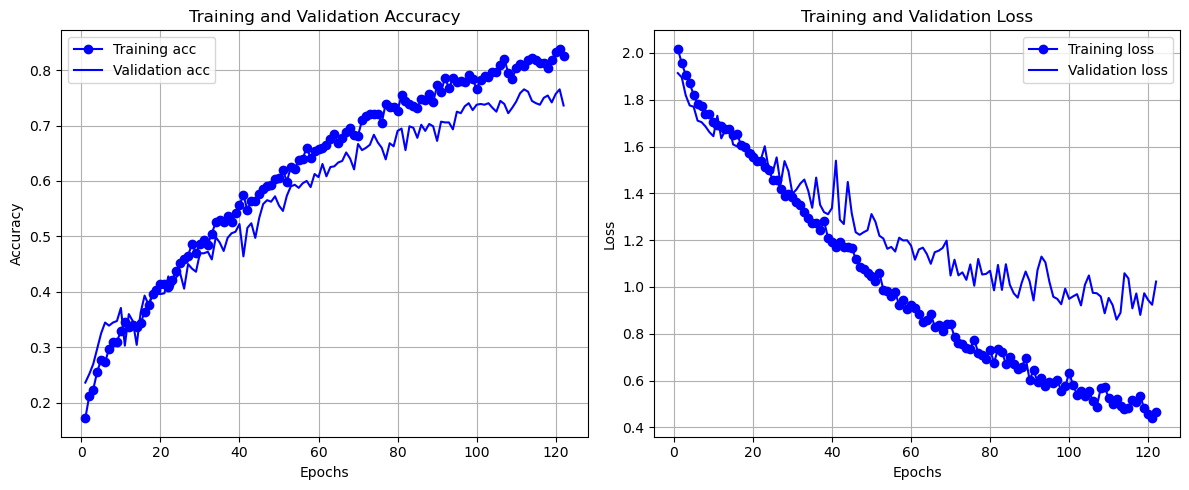

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Create a figure with 2 subplots horizontally
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation accuracy
ax1.plot(epochs, acc, 'bo-', label='Training acc')
ax1.plot(epochs, val_acc, 'b-', label='Validation acc')
ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Plot training and validation loss
ax2.plot(epochs, loss, 'bo-', label='Training loss')
ax2.plot(epochs, val_loss, 'b-', label='Validation loss')
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [12]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

 1/23 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [13]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.90      0.86      0.88        96
        calm       0.70      0.89      0.78       100
     disgust       0.68      0.80      0.73        99
        fear       0.80      0.73      0.76        90
       happy       0.88      0.66      0.75       105
     neutral       0.54      0.65      0.59        48
         sad       0.81      0.71      0.76       103
    surprise       0.80      0.77      0.79        79

    accuracy                           0.77       720
   macro avg       0.76      0.76      0.76       720
weighted avg       0.78      0.77      0.77       720



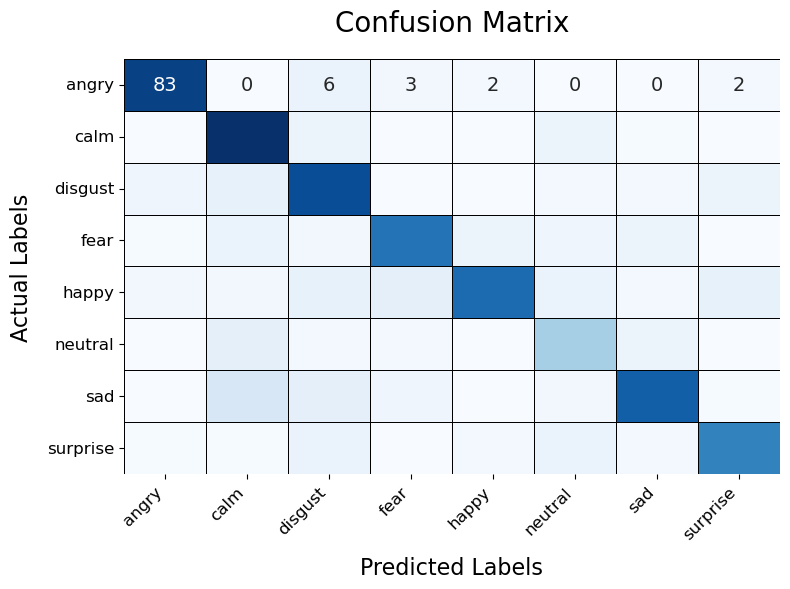

In [14]:
cm = confusion_matrix(y_test, y_pred)
# Create a DataFrame for the confusion matrix
cm_df = pd.DataFrame(cm, index=encoder.categories_[0], columns=encoder.categories_[0])

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', linewidths=0.5, linecolor='black', cbar=False,
            annot_kws={"size": 14})

plt.title('Confusion Matrix', fontsize=20, pad=20)
plt.xlabel('Predicted Labels', fontsize=16, labelpad=10)
plt.ylabel('Actual Labels', fontsize=16, labelpad=10)

plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()

# Display the plot
plt.show()

## Save the trained model

In [15]:
model.save('trained_model/Speech_CNN.h5')